<h1 align='center'><b>Машинное обучение в бизнесе<b></h1>

<h1 align='left'>Урок 1. Data-driven-подход на примере задачи маршрутизации заявок в helpdesk</h1>

<h2 align='center'>Домашняя работа</h2>

<b> В задании нужно загрузить датасет с данными оттока и ответить на несколько вопросов (написать код). При этом сам датасет уже есть и его необязательно качать с репозитория</b>

Цель задания: проверить базовые навыки работы студентов с Pandas, умение проводить такой же базовый EDA (exploratory data analysis), делать feature engineering и обучать и валидировать модель.

Список столбцов с типами данных в датасете:

- customerID           object
- gender               object
- SeniorCitizen         int64
- Partner              object
- Dependents           object
- tenure                int64
- PhoneService         object
- MultipleLines        object
- InternetService      object
- OnlineSecurity       object
- OnlineBackup         object
- DeviceProtection     object
- TechSupport          object
- StreamingTV          object
- StreamingMovies      object
- Contract             object
- PaperlessBilling     object
- PaymentMethod        object
- MonthlyCharges      float64
- TotalCharges         object
- Churn                object

In [1]:
# !pip install mplcyberpunk

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, log_loss
import dill

# Visual libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import mplcyberpunk

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})
# plt.style.use('seaborn')
plt.style.use('cyberpunk')

import warnings
warnings.filterwarnings('ignore')

https://github.com/dhaitz/mplcyberpunk

In [3]:
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


##### 1. Какое соотношение мужчин и женщин в представленном наборе данных?

In [4]:
counts = df['gender'].value_counts(normalize=True)
counts

Male      0.504756
Female    0.495244
Name: gender, dtype: float64

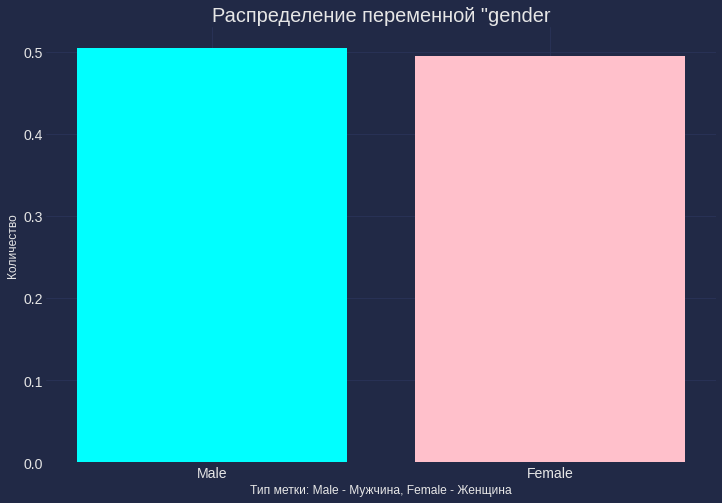

In [5]:
plt.figure(figsize=(12,8))
plt.title('Распределение переменной "gender', fontsize=20)
# sns.barplot(counts.index, counts.values)
plt.bar(counts.index, counts.values, color=['cyan', 'pink'])
plt.xlabel('Тип метки: Male - Мужчина, Female - Женщина', fontsize=12)
plt.ylabel('Количество', fontsize=12)
plt.show()

##### 2. Какое количество уникальных значений у поля InternetService?

In [6]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

##### 3. Выведите статистики по полю TotalCharges (median, mean, std).

In [7]:
df['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

В чем странность того, что вы получили? (подсказка: смотреть нужно на тип данных)

_Несмотря на внешнюю похожесть на числовой признак, 'TotalCharges' является текстовым. Тип данных object._

##### 4. Сделайте замену значений поля PhoneService  на числовые (Yes->1, No->0)

In [8]:
df['PhoneService'] =df['PhoneService'].map({'Yes': 1, 'No': 0})

5. Сделайте замену пробелов в поле TotalCharges на np.nan и приведите поле к типу данных float32. Затем заполните оставшиеся пропуски значением 0 с помощью метода fillna у столбца. Снова выведите статистики и сравните с тем, что вы видели в вопросе 3

In [9]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype('float32').fillna(0)
df['TotalCharges'].describe()

count    7043.000000
mean     2279.732178
std      2266.794434
min         0.000000
25%       398.549988
50%      1394.550049
75%      3786.599976
max      8684.799805
Name: TotalCharges, dtype: float64

##### 6. Сделайте замену значений поля Churn на числовые (Yes -> 1, No - 0)

In [10]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

##### 7. Сделайте замену значений полей StreamingMovies, StreamingTV, TechSupport  на числовые (Yes -> 1, No -> 0, No internet service->0)

In [11]:
for col in ['StreamingMovies', 'StreamingTV', 'TechSupport']:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

##### 8. Заполните пропуски в поле PhoneService значением 0

In [12]:
df['PhoneService'] = df['PhoneService'].fillna(0)

#### 8. Для нашего датасета оставьте только указанный ниже список полей, удалив все другие и выведите верхние 3 строки

In [13]:
columns = ['gender', 'tenure', 'PhoneService', 'TotalCharges',
           'StreamingMovies', 'StreamingTV', 'TechSupport', 'Churn']

In [14]:
df = df[columns]
df.head(3)

,gender,tenure,PhoneService,TotalCharges,StreamingMovies,StreamingTV,TechSupport,Churn
0,Female,1,0,29.850000,0,0,0,0
1,Male,34,1,1889.500000,0,0,0,0
2,Male,2,1,108.150002,0,0,0,1


##### 9. Разделите датасет на тренировочную и тестовую выборку (подсказка - воспользуйтесь train_test_split из sklearn.model_selection. Ссылка - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [15]:
features = ['gender', 'tenure', 'PhoneService', 'TotalCharges', 'StreamingMovies', 'StreamingTV', 'TechSupport']
target = 'Churn'

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

##### 10. соберите pipeline для поля gender (нужно разобраться и изучить https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) из классов ColumnSelector и OHEEncoder, которые уже написаны ниже заранее

In [17]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use for non-numeric columns in data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns =[col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

gender = Pipeline([('selector', ColumnSelector(key='gender')),
                   ('coder', OHEEncoder(key='gender'))])

##### 11. Вызовите метод fit_transform у пайплайна gender и передайте туда нашу тренировочную выборку (пример по ссылке из документации https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline.fit)

In [18]:
gender.fit_transform(X_train)

,gender_Female,gender_Male
2142,1,0
1623,1,0
6074,0,1
1362,0,1
6754,0,1
...,...,...
3772,0,1
5191,1,0
5226,0,1
5390,0,1


##### 12. Здесь код писать уже не нужно (все сделано за вас). К полю tenure применяем StandardScaler (нормируем и центрируем). Ссылка - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
Вопрос - в каких случаях это может быть полезно?

In [19]:
tenure = Pipeline([
    ('selector', NumberSelector(key='tenure')),
    ('standart', StandardScaler())
])

Когда параметры датасета сильно различаются между диапазонами или, когда они измеряются в разных единицах измерения.

##### 13. Напишите аналогичный (как для tenure) преобразователь поля TotalCharges

In [20]:
TotalCharges = Pipeline([
    ('selector', NumberSelector(key="TotalCharges")),
    ('standart', StandardScaler())
])

Объединение всех “кубиков” очень легко сделать таким образом

In [21]:
number_features = Pipeline([
    ('selector', ColumnSelector(key=['PhoneService',
                                     'StreamingMovies',
                                     'StreamingTV',
                                     'TechSupport']))
])

In [22]:
feats = FeatureUnion([('tenure', tenure),
                      ('TotalCharges', TotalCharges),
                      ('continuos_features', number_features),
                      ('gender', gender)
])
feature_processing = Pipeline([('feats', feats)])

На этом этапе, что мы сделали:
1. написали преобразователь поля gender, который делает OHE кодирование
2. написали преобразователь для поля tenure, который нормирует и центрирует его
3. повторили п. 2 для поля TotalCharges
4. для всех остальных просто взяли признаки как они есть, без изменений

У нас уже готов наш пайплайн, который преобразовывает признаки. Давайте обучим модель поверх него. В качестве модели возьмем RandomForestClassifier

In [23]:
df

,gender,tenure,PhoneService,TotalCharges,StreamingMovies,StreamingTV,TechSupport,Churn
0,Female,1,0,29.850000,0,0,0,0
1,Male,34,1,1889.500000,0,0,0,0
2,Male,2,1,108.150002,0,0,0,1
3,Male,45,0,1840.750000,0,0,1,0
4,Female,2,1,151.649994,0,0,0,1
...,...,...,...,...,...,...,...,...
7038,Male,24,1,1990.500000,1,1,1,0
7039,Female,72,1,7362.899902,1,1,0,0
7040,Female,11,0,346.450012,0,0,0,0
7041,Male,4,1,306.600006,0,0,0,1


In [24]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('tenure',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='tenure')),
                                                                 ('standart',
                                                                  StandardScaler())])),
                                                ('TotalCharges',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='TotalCharges')),
                                                                 ('standart',
                                                                  StandardScaler())])),
                                                ('continuos_features',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key=['PhoneService',
                                                                                      'StreamingMovies',
                                                                                      'StreamingTV',
                                                                                      'TechSupport']))])),
                                                ('gender',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(key='gender')),
                                                                 ('coder',
                                                                  OHEEncoder(key='gender'))]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

##### 14. Сделайте прогноз вероятности оттока для X_test с помощью нашего предобученного на предыдущем шаге пайплайна и убедитесь что вам возвращаются вероятности для 2 классов

In [25]:
pipeline.predict_proba(X_test)

array([[0.26, 0.74],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.92, 0.08],
       [0.99, 0.01],
       [0.04, 0.96]])

##### 15. Посчитайте метрики качества получившейся модели (roc_auc, logloss)

In [26]:
print(f'Метрика roc_auc_score: {roc_auc_score(y_true=y_test, y_score=pipeline.predict_proba(X_test)[:, 1])}')
print(f'Метрика  log_loss score: {log_loss(y_true=y_test, y_pred=pipeline.predict_proba(X_test)[:, 1])}')

Метрика roc_auc_score: 0.8012281718716034
Метрика  log_loss score: 0.6072613015282818


### Сохраним наш пайплайн

In [27]:
with open('model_RF.dill', 'wb') as f:
    dill.dump(pipeline, f)